In [1]:
import os
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
import sampler_evaluation
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
import sampler_evaluation
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_comparison.samplers.hamiltonianmontecarlo.unadjusted.underdamped_langevin import unadjusted_lmc, unadjusted_lmc_no_tuning
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc_no_tuning
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc_no_tuning
import jax.numpy as jnp
import blackjax
from sampler_comparison.samplers.general import (
    with_only_statistics,
    make_log_density_fn,
)
import blackjax.mcmc.metrics as metrics
from functools import partial
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.banana import banana


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

In [2]:
# make an initial state for the integrator

# initial_state = blackjax.dynamic_hmc.init(
#         position=initial_position,
#         logdensity_fn=logdensity_fn,
#         random_generator_arg=jax.random.key(0),
#         # metric=metrics.default_metric(inverse_mass_matrix)
#     )

# initial_state = blackjax.mclmc.init(
#         position=initial_position,
#         logdensity_fn=logdensity_fn,
#         rng_key=jax.random.key(3),
#         # metric=metrics.default_metric(inverse_mass_matrix)
#     )
# sampler = partial(unadjusted_mclmc_no_tuning,
#                 initial_state=initial_state,
#                 integrator_type='velocity_verlet',
#                 step_size=5e-1,
#                 L=5e-2,
#                 inverse_mass_matrix=inverse_mass_matrix,
#             )

# sampler = samplers['nuts']

# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

Array([0.53711826, 2.137739  ], dtype=float32)

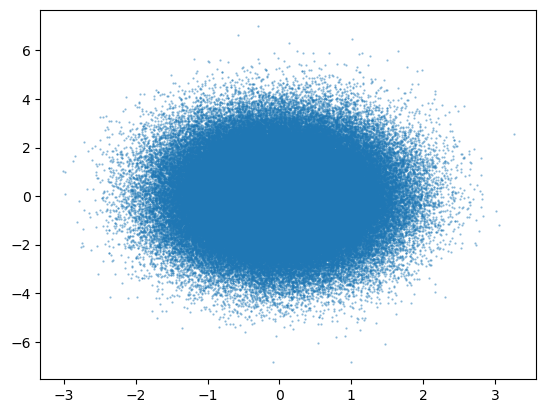

In [11]:

# model=sampler_evaluation.models.Rosenbrock(D=1)
model = IllConditionedGaussian(ndims=2, condition_number=2, eigenvalues='log')


initial_position = jax.random.normal(jax.random.PRNGKey(0), (model.ndims,))


logdensity_fn = make_log_density_fn(model)


# print(model.cov)

inverse_mass_matrix = jnp.ones((model.ndims,))
# inverse_mass_matrix = jnp.ones((model.ndims,))
# inverse_mass_matrix = model.cov
initial_state = blackjax.langevin.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        rng_key=jax.random.key(0),
        metric=metrics.default_metric(inverse_mass_matrix)
    )

sampler = partial(unadjusted_lmc_no_tuning,
                initial_state=initial_state,
                integrator_type='velocity_verlet',
                step_size=5e-1,
                L=1e-1,
                # step_size=0.09,
                # L=1e0,
                inverse_mass_matrix=inverse_mass_matrix,
            )

samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=200000,
        initial_position=None, 
        key=jax.random.key(0))

samples[-1]
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)
jnp.mean(samples**2, axis=0)

Array([0.09987223, 9.799665  ], dtype=float32)

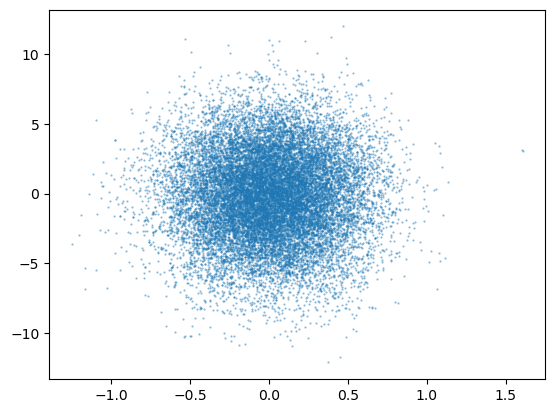

In [8]:

# model=sampler_evaluation.models.Rosenbrock(D=1)
model = IllConditionedGaussian(ndims=2, condition_number=100, eigenvalues='log')


initial_position = jax.random.normal(jax.random.PRNGKey(0), (model.ndims,))


logdensity_fn = make_log_density_fn(model)


# print(model.cov)

inverse_mass_matrix = jnp.eye(model.ndims)
# inverse_mass_matrix = jnp.ones((model.ndims,))
# inverse_mass_matrix = jnp.sqrt(model.cov)
initial_state = blackjax.dynamic_hmc.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        random_generator_arg=jax.random.key(0),
        # metric=metrics.default_metric(inverse_mass_matrix)
    )

sampler = partial(adjusted_hmc_no_tuning,
                initial_state=initial_state,
                integrator_type='velocity_verlet',
                step_size=5e-3,
                L=1e0,
                # step_size=0.09,
                # L=1e0,
                inverse_mass_matrix=inverse_mass_matrix,
            )

samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=20000,
        initial_position=None, 
        key=jax.random.key(0))

samples[-1]
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)
jnp.mean(samples**2, axis=0)

step size (Array(0.32783478, dtype=float32), Array(57573.047, dtype=float32))
params MCLMCAdaptationState(L=Array(1.0066108, dtype=float32), step_size=Array(0.32260057, dtype=float32), inverse_mass_matrix=Array([0.73956394, 1.4887525 ], dtype=float32))


Array([0.542049, 2.142803], dtype=float32)

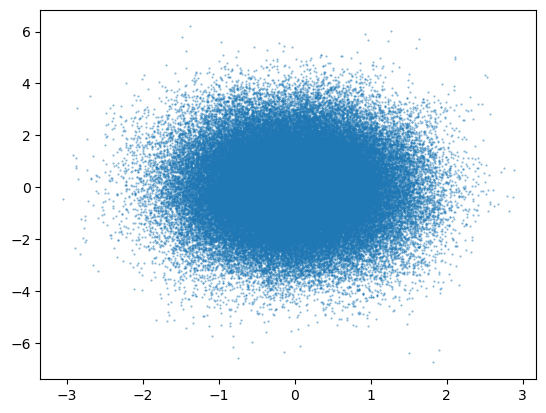

In [25]:
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState



model = IllConditionedGaussian(ndims=2, condition_number=2, eigenvalues='log')

params = MCLMCAdaptationState(
                # 1, 0.25, inverse_mass_matrix=jnp.array([0.7, 1.4]))
                1, 0.25, inverse_mass_matrix=jnp.array([1.0,1.0]))
            


sampler = partial(unadjusted_lmc,desired_energy_var=5e-1, num_tuning_steps=20000, diagonal_preconditioning=True, num_windows=1, params=params)

initial_position = jax.random.normal(jax.random.PRNGKey(0), (model.ndims,))



samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=100000,
        initial_position=initial_position, 
        key=jax.random.key(0))



plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)
jnp.mean(samples**2, axis=0)


In [35]:
model = IllConditionedGaussian(ndims=2, condition_number=100, eigenvalues='log')

samples_nuts, metadata = samplers['nuts'](return_samples=True)(
        # model=gym.targets.rosenbrock.Rosenbrock(D=2), 
        model=model, 
        num_steps=100000,
        # initial_position=model.sample(seed=jax.random.key(0)), 
        initial_position=initial_position, 
        key=jax.random.PRNGKey(0))

# plot samples
jnp.mean(samples_nuts**2, axis=0)
# plt.scatter(samples_nuts[:,0], samples_nuts[:,1], alpha=0.5, s=0.3)

Array([0.09906327, 9.965221  ], dtype=float32)

{'L': Array(0.92434824, dtype=float32),
 'step_size': Array(0.19327478, dtype=float32),
 'acc_rate': nan,
 'num_tuning_grads': 3333,
 'num_grads_per_proposal': 1}

In [17]:
# samples.shape
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

error_at_each_step = get_standardized_squared_error(
    jnp.expand_dims(samples,0), 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )

error_at_each_step.shape

# gradient_calls_per_proposal = metadata['num_grads_per_proposal'].mean()

# samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal

# print("Gradient calls to low error", samples_to_low_err)

(1, 10000)

Array(3.7053496e-06, dtype=float32)

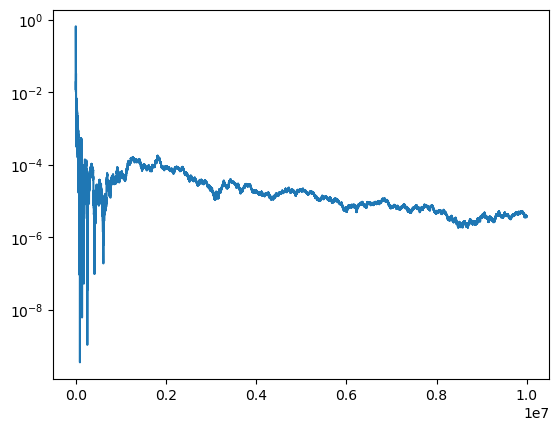

In [7]:
# plot error_at_each_step
plt.plot(error_at_each_step[0,:])
plt.yscale('log')
# plt.xscale('log')
error_at_each_step[0, -1]

In [24]:

b2 = (((samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_mean**2)
b2
phi = lambda b2 : 4*jnp.sqrt(b2)**3
phi(b2.mean())


Array(8.0689674e-08, dtype=float32)

## Investigate step size tuning for Langevin


In [4]:
def run_ulmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-1):
    init_key, tune_key, run_key = jax.random.split(key, 3)
    ndims = initial_position.shape[0]
    print("ndims", ndims)

    integrator = blackjax.mcmc.integrators.velocity_verlet

    # create an initial state for the sampler
    initial_state = blackjax.langevin.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key,
        metric=blackjax.mcmc.metrics.default_metric((jnp.ones(ndims,)))
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.langevin.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=integrator,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    state = initial_state

    (
        state,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance,
        euclidean=True,
    )

    
    # blackjax_mclmc_sampler_params = blackjax.adaptation.mclmc_adaptation.MCLMCAdaptationState(
    #             L=1e-1, step_size=5e-2, inverse_mass_matrix=jnp.ones((ndims,))
    #         )

    # (
    #     state,
    #     blackjax_mclmc_sampler_params,
        
    # ) = blackjax.adaptation.mclmc_adaptation.make_L_step_size_adaptation(
    #     kernel=kernel,
    #     dim = ndims,
    #     frac_tune1=2.0,
    #     frac_tune2=0.0,
    #     # num_steps=num_steps,
    #     # state=initial_state,
    #     diagonal_preconditioning=False,
    #     desired_energy_var=desired_energy_variance,
    #     euclidean=True,
    # )(state, blackjax_mclmc_sampler_params, num_steps, tune_key)

    print("step size", blackjax_mclmc_sampler_params.step_size)
    print("L", blackjax_mclmc_sampler_params.L)
    # print("inverse mass matrix", blackjax_mclmc_sampler_params.inverse_mass_matrix)


    # use the quick wrapper to build a new kernel with the tuned parameters

    sampling_alg = blackjax.langevin(
            logdensity_fn=logdensity_fn,
            L=blackjax_mclmc_sampler_params.L,
            step_size=blackjax_mclmc_sampler_params.step_size,
            inverse_mass_matrix=blackjax_mclmc_sampler_params.inverse_mass_matrix,
            integrator=integrator,
        )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=state,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )

    return samples, state, blackjax_mclmc_sampler_params, run_key

In [11]:


D = 1
logdensity_fn = make_log_density_fn(sampler_evaluation.models.Rosenbrock(D=D))
# logdensity_fn =  lambda x: -0.5 * jnp.sum(jnp.square(x))
num_steps = 50000
transform = lambda state, info: jnp.array([state.position[0], state.position[D]])

rng_key = jax.random.PRNGKey(1)

sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = jax.pmap(lambda key: run_ulmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=jnp.ones((D*2,)),
    key=key,
    transform=transform,
    desired_energy_variance=5e-4,
))(
    jax.random.split(sample_key, 1)
)

samples.shape


ndims 2
step size Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
L Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
adaptive state (Array(3.2227483e+21, dtype=float32), Array(0.00026019, dtype=float32))


(1, 50000, 2)

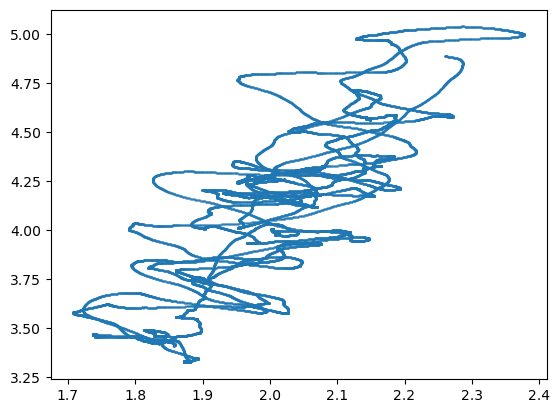

In [12]:
# plot samples
plt.scatter(samples[0, :,0], samples[0,:,1], alpha=0.5, s=0.3)

In [7]:

error_at_each_step = get_standardized_squared_error(
    samples, 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )

error_at_each_step = jnp.nanmedian(error_at_each_step,axis=0)

gradient_calls_per_proposal = metadata['num_grads_per_proposal']

samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal

print("Gradient calls to low error", samples_to_low_err)

# gradient_calls_per_proposal

final error is 0.0025210874155163765
Gradient calls to low error 10244.0


In [ ]:
9452.0